# SISSOEnsemble Demonstration: Interpretable Symbolic Regression with Calibrated UQ

This notebook demonstrates **SISSOEnsemble** - a shallow ensemble of SISSO equations with calibrated uncertainty quantification.

## What is SISSOEnsemble?

SISSOEnsemble combines:
- **SISSO** (Sure Independence Screening and Sparsifying Operator) for discovering interpretable symbolic equations
- **DPOSE-style shallow ensembles** for calibrated uncertainty quantification

Key features:
- ✅ **Interpretable equations** - each ensemble member is a readable symbolic expression
- ✅ **Calibrated uncertainties** - trained with CRPS or NLL loss
- ✅ **Ensemble diversity** - different equation complexities (n_term values)
- ✅ **Post-hoc calibration** - optional validation-based calibration
- ✅ **Uncertainty propagation** - via `predict_ensemble()`

**References:**
- TorchSISSO: https://arxiv.org/abs/2410.01752
- DPOSE: Kellner & Ceriotti (2024), *Machine Learning: Science and Technology*

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set style
plt.style.use("default")
plt.rcParams["figure.dpi"] = 100

print("Imports successful!")

Imports successful!


## 1. Basic Example: Simple Additive Function

Let's start with a simple example where the true function is `y = x0 + x1`.

In [2]:
from pycse.sklearn import SISSOEnsemble

# Generate simple additive data
np.random.seed(42)
X = np.random.rand(100, 2)
y = X[:, 0] + X[:, 1] + 0.05 * np.random.randn(100)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("True function: y = x0 + x1 + noise")

Training samples: 80
Test samples: 20
True function: y = x0 + x1 + noise


In [3]:
# Fit SISSOEnsemble
model = SISSOEnsemble(
    n_models=5,  # Number of equations to discover
    n_expansion=1,  # Feature expansion depth
    n_terms_range=(1, 3),  # Range of terms per equation
    loss_type="crps",  # CRPS loss for calibrated uncertainties
    feature_names=["x0", "x1"],
)

model.fit(X_train, y_train)

print(f"\nDiscovered {model.n_ensemble_} unique equations:")
for i, eq in enumerate(model.equations_):
    print(f"  {i + 1}. {eq}")

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  1.021106*x0+0.4865740284710642


RMSE:  0.2987923429777587
R2:: 0.5349659721037425


************************************************ Time taken to generate one dimensional equation:  0.0006079673767089844  seconds ************************************************ 



************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created **


Discovered 3 unique equations:
  1. 1.021106*x0+0.4865740284710642
  2.  + 1.0127256781*x0   + 1.0237079950*x1  -0.014166425030515684
  3.  + 0.5063628391*x0   + 1.0237079950*x1   + 0.5063628391*x0  -0.014166425030515684


In [4]:
# Evaluate on test set
y_pred, y_std = model.predict(X_test, return_std=True)

mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
r2 = model.score(X_test, y_test)

print("Test Set Performance:")
print(f"  MAE:  {mae:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  R²:   {r2:.6f}")
print(f"  Uncertainty range: [{y_std.min():.4f}, {y_std.max():.4f}]")

Test Set Performance:
  MAE:  0.037831
  RMSE: 0.047953
  R²:   0.978143
  Uncertainty range: [0.0217, 0.3273]


## 2. Interpolation and Extrapolation with Gaps

A key test for uncertainty quantification is how the model behaves:
- **In gaps**: regions without training data (interpolation)
- **Beyond data range**: extrapolation

Good UQ should show increased uncertainty in these regions.

In [5]:
# Generate 1D data with a gap in the middle
np.random.seed(42)

# Left region: [0, 0.35]
x_left = np.linspace(0, 0.35, 40)
# Right region: [0.65, 1]
x_right = np.linspace(0.65, 1, 40)

# Combine (gap in middle: [0.35, 0.65])
x_raw = np.concatenate([x_left, x_right])

# Just use x as feature - SISSO will discover x² using pow(2) operator
X_train = x_raw[:, None]

# True function: quadratic
y_train = 2 * x_raw**2 + x_raw + 0.05 * np.random.randn(len(x_raw))

print(f"Training samples: {len(X_train)}")
print("Data range: [0, 0.35] ∪ [0.65, 1]")
print("Gap: [0.35, 0.65]")
print("True function: y = 2x² + x + noise")

Training samples: 80
Data range: [0, 0.35] ∪ [0.65, 1]
Gap: [0.35, 0.65]
True function: y = 2x² + x + noise


In [6]:
# Fit SISSOEnsemble with rich operator set
# Note: Avoid pow(0.5) (sqrt) since we extrapolate to negative x where sqrt is undefined
model_gap = SISSOEnsemble(
    n_models=5,
    operators=["+", "-", "*", "/", "pow(2)", "pow(3)", "exp", "sin", "cos", "tanh"],
    n_expansion=2,  # Allow feature combinations
    n_terms_range=(1, 3),
    loss_type="crps",
    feature_names=["x"],
)

model_gap.fit(X_train, y_train)

print(f"Discovered {model_gap.n_ensemble_} equations:")
for i, eq in enumerate(model_gap.equations_):
    print(f"  {i + 1}. {eq}")

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Starting 1 level of feature expansion...************************************************ 

************************************************ 1 Feature Expansion Completed with feature space size::: 7 ************************************************ 

************************************************ Time taken to create the space is::: 0.0011067390441894531  Seconds...************************************************ 

************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  -6.390047*(cos(x))+6.512281634397345


RMSE:  0.0643695498197806
R2:: 0.9961476447537809


********************************************

Discovered 3 equations:
  1. -6.390047*(cos(x))+6.512281634397345
  2. -5.3653083918*(cos(x))   + 0.6515613468*(tanh(x))  +5.38924313588494
  3.  + 3.4810793159*(x)**2   + 2.3157147475*x  -1.6479812160*(exp(x))  +1.6705521315051295


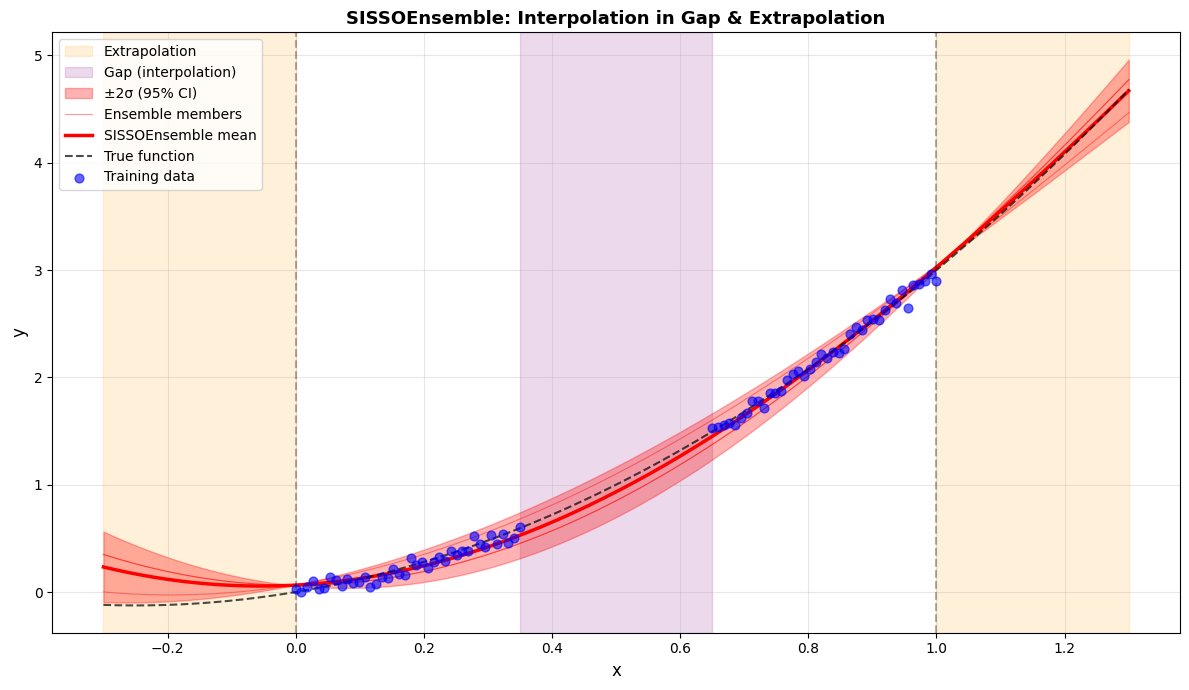


Key observations:
  • Orange regions: Extrapolation beyond training data
  • Purple region: Gap where no training data exists
  • Light red lines: Individual ensemble member predictions
  • Bold red line: Ensemble mean prediction
  • Uncertainty band shows model confidence


In [7]:
# Predict over extended range (including gap and extrapolation)
x_plot_raw = np.linspace(-0.3, 1.3, 200)
x_plot = x_plot_raw[:, None]  # 1D feature

y_pred, y_std = model_gap.predict(x_plot, return_std=True)

# Get individual ensemble predictions
ensemble_preds = model_gap.predict_ensemble(x_plot)

# True function for comparison
y_true = 2 * x_plot_raw**2 + x_plot_raw

# Plot
fig, ax = plt.subplots(figsize=(12, 7))

# Extrapolation regions
ax.axvspan(-0.3, 0, alpha=0.15, color="orange", label="Extrapolation")
ax.axvspan(1, 1.3, alpha=0.15, color="orange")

# Gap region
ax.axvspan(0.35, 0.65, alpha=0.15, color="purple", label="Gap (interpolation)")

# Uncertainty band
ax.fill_between(
    x_plot_raw, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.3, color="red", label="±2σ (95% CI)"
)

# Individual ensemble members (lighter lines)
for i in range(ensemble_preds.shape[1]):
    label = "Ensemble members" if i == 0 else None
    ax.plot(x_plot_raw, ensemble_preds[:, i], "r-", linewidth=0.8, alpha=0.4, label=label)

# Mean prediction (bold line)
ax.plot(x_plot_raw, y_pred, "r-", linewidth=2.5, label="SISSOEnsemble mean")
ax.plot(x_plot_raw, y_true, "k--", linewidth=1.5, label="True function", alpha=0.7)

# Training data
ax.scatter(x_raw, y_train, c="blue", s=40, alpha=0.6, label="Training data", zorder=5)

# Data boundaries
ax.axvline(0, color="black", linestyle="--", alpha=0.3)
ax.axvline(1, color="black", linestyle="--", alpha=0.3)

ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("y", fontsize=12)
ax.set_title("SISSOEnsemble: Interpolation in Gap & Extrapolation", fontsize=13, fontweight="bold")
ax.legend(fontsize=10, loc="upper left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("  • Orange regions: Extrapolation beyond training data")
print("  • Purple region: Gap where no training data exists")
print("  • Light red lines: Individual ensemble member predictions")
print("  • Bold red line: Ensemble mean prediction")
print("  • Uncertainty band shows model confidence")

## 3. Comparing Loss Functions: CRPS vs NLL vs MSE

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Starting 1 level of feature expansion...************************************************ 

************************************************ 1 Feature Expansion Completed with feature space size::: 7 ************************************************ 

************************************************ Time taken to create the space is::: 0.0006642341613769531  Seconds...************************************************ 

************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  -6.390047*(cos(x))+6.512281634397345


RMSE:  0.0643695498197806
R2:: 0.9961476447537809


********************************************

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Starting 1 level of feature expansion...************************************************ 

************************************************ 1 Feature Expansion Completed with feature space size::: 7 ************************************************ 

************************************************ Time taken to create the space is::: 0.0004379749298095703  Seconds...************************************************ 

************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  -6.390047*(cos(x))+6.512281634397345


RMSE:  0.0643695498197806
R2:: 0.9961476447537809


********************************************

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Starting 1 level of feature expansion...************************************************ 

************************************************ 1 Feature Expansion Completed with feature space size::: 7 ************************************************ 

************************************************ Time taken to create the space is::: 0.0004439353942871094  Seconds...************************************************ 

************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  -6.390047*(cos(x))+6.512281634397345


RMSE:  0.0643695498197806
R2:: 0.9961476447537809


********************************************

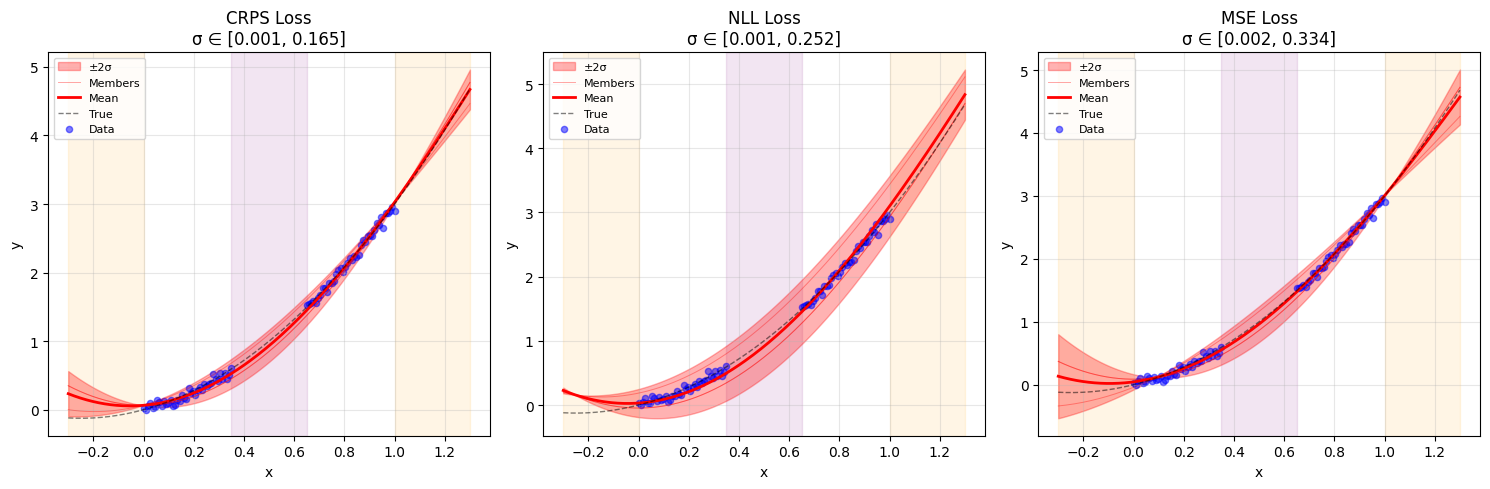


Loss function comparison:
  CRPS: Robust, single-stage training (recommended)
  NLL:  Can capture heteroscedasticity well
  MSE:  No uncertainty training (baseline)

Light red lines show individual ensemble member predictions.


In [8]:
# Compare loss functions
loss_types = ["crps", "nll", "mse"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, loss_type in enumerate(loss_types):
    ax = axes[idx]

    # Fit model with rich operator set (no sqrt to avoid NaN for x<0)
    model_loss = SISSOEnsemble(
        n_models=5,
        operators=["+", "-", "*", "/", "pow(2)", "pow(3)", "exp", "sin", "cos", "tanh"],
        n_expansion=2,
        n_terms_range=(1, 3),
        loss_type=loss_type,
        feature_names=["x"],
    )
    model_loss.fit(X_train, y_train)

    # Predict
    y_pred, y_std = model_loss.predict(x_plot, return_std=True)

    # Get individual ensemble predictions
    ensemble_preds = model_loss.predict_ensemble(x_plot)

    # Plot regions
    ax.axvspan(-0.3, 0, alpha=0.1, color="orange")
    ax.axvspan(1, 1.3, alpha=0.1, color="orange")
    ax.axvspan(0.35, 0.65, alpha=0.1, color="purple")

    # Uncertainty band
    ax.fill_between(
        x_plot_raw, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.3, color="red", label="±2σ"
    )

    # Individual ensemble members (lighter lines)
    for i in range(ensemble_preds.shape[1]):
        label = "Members" if i == 0 else None
        ax.plot(x_plot_raw, ensemble_preds[:, i], "r-", linewidth=0.7, alpha=0.35, label=label)

    # Mean prediction and true function
    ax.plot(x_plot_raw, y_pred, "r-", linewidth=2, label="Mean")
    ax.plot(x_plot_raw, y_true, "k--", linewidth=1, label="True", alpha=0.5)
    ax.scatter(x_raw, y_train, c="blue", s=20, alpha=0.5, label="Data")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{loss_type.upper()} Loss\nσ ∈ [{y_std.min():.3f}, {y_std.max():.3f}]")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLoss function comparison:")
print("  CRPS: Robust, single-stage training (recommended)")
print("  NLL:  Can capture heteroscedasticity well")
print("  MSE:  No uncertainty training (baseline)")
print("\nLight red lines show individual ensemble member predictions.")

## 4. Post-hoc Calibration with Validation Data

In [9]:
# Generate more data for validation
np.random.seed(123)
X_full = np.random.rand(150, 2)
y_full = X_full[:, 0] + 2 * X_full[:, 1] + 0.1 * np.random.randn(150)

# Split into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Training: 90, Validation: 30, Test: 30


In [10]:
# Fit without calibration
model_uncalib = SISSOEnsemble(
    n_models=5, n_expansion=1, n_terms_range=(1, 3), feature_names=["x0", "x1"]
)
model_uncalib.fit(X_train, y_train)

# Fit with calibration
model_calib = SISSOEnsemble(
    n_models=5, n_expansion=1, n_terms_range=(1, 3), feature_names=["x0", "x1"]
)
model_calib.fit(X_train, y_train, val_X=X_val, val_y=y_val)

print(f"Uncalibrated model calibration factor: {model_uncalib.calibration_factor_:.4f}")
print(f"Calibrated model calibration factor: {model_calib.calibration_factor_:.4f}")

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  1.883255*x1+0.493439303428595


RMSE:  0.28696723757100123
R2:: 0.7692184007918726


************************************************ Time taken to generate one dimensional equation:  0.00030422210693359375  seconds ************************************************ 



************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created *

************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created ************************************************ 

Equation:  1.883255*x1+0.493439303428595


RMSE:  0.28696723757100123
R2:: 0.7692184007918726


************************************************ Time taken to generate one dimensional equation:  0.00031375885009765625  seconds ************************************************ 



************************************************ Starting Feature Space Construction in cpu ************************************************ 



************************************************ Given Number of features in SIS screening is greater than the feature space created, changing the SIS features to shape of features created *

Uncalibrated model calibration factor: 1.0000
Calibrated model calibration factor: 0.5345


In [11]:
# Compare on test set
y_pred_uncalib, y_std_uncalib = model_uncalib.predict(X_test, return_std=True)
y_pred_calib, y_std_calib = model_calib.predict(X_test, return_std=True)

# Z-scores (should have std ~1 if well-calibrated)
z_uncalib = (y_test - y_pred_uncalib) / y_std_uncalib
z_calib = (y_test - y_pred_calib) / y_std_calib

print("Calibration Quality (Z-score std should be ~1.0):")
print(f"  Uncalibrated: Z-score std = {np.std(z_uncalib):.4f}")
print(f"  Calibrated:   Z-score std = {np.std(z_calib):.4f}")

Calibration Quality (Z-score std should be ~1.0):
  Uncalibrated: Z-score std = 1.0194
  Calibrated:   Z-score std = 1.9073


## 5. Ensemble Predictions for Uncertainty Propagation

In [12]:
# Get full ensemble predictions
ensemble_preds = model_calib.predict_ensemble(X_test)

print(f"Ensemble predictions shape: {ensemble_preds.shape}")
print(f"  {len(X_test)} samples × {model_calib.n_ensemble_} ensemble members")

# Each column is a different equation's prediction
print("\nPrediction range per ensemble member:")
for i in range(ensemble_preds.shape[1]):
    print(f"  Member {i + 1}: [{ensemble_preds[:, i].min():.3f}, {ensemble_preds[:, i].max():.3f}]")

Ensemble predictions shape: (30, 3)
  30 samples × 3 ensemble members

Prediction range per ensemble member:
  Member 1: [0.531, 2.179]
  Member 2: [0.118, 2.871]
  Member 3: [0.293, 2.955]


In [13]:
# Uncertainty propagation example: z = exp(y)
z_ensemble = np.exp(ensemble_preds)
z_mean = z_ensemble.mean(axis=1)
z_std = z_ensemble.std(axis=1)

# Compare with naive propagation
y_mean, y_std = model_calib.predict(X_test, return_std=True)
z_mean_naive = np.exp(y_mean)
z_std_naive = z_mean_naive * y_std  # Linear approximation: dz/dy * dy

print("Uncertainty propagation through z = exp(y):")
print(f"  Ensemble method:  z_std ∈ [{z_std.min():.4f}, {z_std.max():.4f}]")
print(f"  Naive (linear):   z_std ∈ [{z_std_naive.min():.4f}, {z_std_naive.max():.4f}]")

Uncertainty propagation through z = exp(y):
  Ensemble method:  z_std ∈ [0.1578, 4.6944]
  Naive (linear):   z_std ∈ [0.0860, 2.7644]


## 6. Viewing the Discovered Equations

A key advantage of SISSOEnsemble over neural network ensembles is **interpretability**.

In [14]:
# Display discovered equations
print("Discovered Symbolic Equations:")
print("=" * 60)
for i, eq in enumerate(model_calib.equations_):
    print(f"Equation {i + 1}: {eq}")
print("=" * 60)

print("\nTrue function: y = x0 + 2*x1")
print("\nNote: Each equation provides a different symbolic approximation.")
print("The ensemble combines them for robust predictions with uncertainty.")

Discovered Symbolic Equations:
Equation 1: 1.883255*x1+0.493439303428595
Equation 2:  + 2.0451722551*x1   + 0.9776782440*x0  -0.025811352976412794
Equation 3:  + 2.0451722551*x1   + 0.4888391220*x0   + 0.4888391220*x0  -0.025811352976412794

True function: y = x0 + 2*x1

Note: Each equation provides a different symbolic approximation.
The ensemble combines them for robust predictions with uncertainty.


## 7. Key Takeaways

### What SISSOEnsemble Provides

1. **Interpretable Equations**
   - Each ensemble member is a readable symbolic expression
   - Useful for understanding the underlying relationship

2. **Calibrated Uncertainties**
   - CRPS/NLL training for well-calibrated predictions
   - Optional post-hoc calibration with validation data

3. **Gap and Extrapolation Handling**
   - Uncertainty increases appropriately in sparse regions
   - Ensemble diversity provides robustness

4. **Uncertainty Propagation**
   - Use `predict_ensemble()` for derived quantities
   - Apply any transformation to ensemble members

### Recommended Usage

```python
from pycse.sklearn import SISSOEnsemble

# Basic usage
model = SISSOEnsemble(
    n_models=5,           # Number of equations
    n_expansion=2,        # Feature complexity
    n_terms_range=(1, 3), # Terms per equation
    loss_type='crps',     # Robust loss function
    feature_names=['x0', 'x1', 'x2']
)

# Fit with optional calibration
model.fit(X_train, y_train, val_X=X_val, val_y=y_val)

# Predict with uncertainty
y_pred, y_std = model.predict(X_test, return_std=True)

# View equations
for eq in model.equations_:
    print(eq)

# Uncertainty propagation
ensemble = model.predict_ensemble(X_test)
z_ensemble = f(ensemble)  # Apply your function
z_mean, z_std = z_ensemble.mean(axis=1), z_ensemble.std(axis=1)
```

### When to Use SISSOEnsemble

- When you need **interpretable models** (symbolic equations)
- When you want **calibrated uncertainty quantification**
- When data is limited and **extrapolation awareness** is important
- When you need to **propagate uncertainties** through derived quantities

---

**Enjoy interpretable symbolic regression with calibrated UQ!** 🎉